# Project Proposal - Will it Rain Tomorrow?

## Introduction

Modern weather forecasting requires millions of data points, complex mathematical models, and powerful supercomputers<sup>1</sup>. But what if the goal was not to predict "the weather", but rather to predict *whether or not it will rain tomorrow*? Can this less ambitious question be answered accurately using simpler variables, fewer data points, and less computational horsepower?  

Our goal is to answer the question, ***which broad weather variable, when measured today, is most predictive of rain tomorrow?*** We will use the **"Rain in Australia"** dataset, publicly avaialable on Kaggle<sup>2</sup>. It contains more than 140,000 weather observations gathered from locations across Australia over a span of 10 years. The target variable is `RainTomorrow`, a Boolean: `Yes` if it rained the day after, and `No` otherwise.

## Preliminary EDA

### Loading libraries

In [2]:

suppressPackageStartupMessages({
library(tidyverse) 
library(tidymodels)
library(repr)
library(forcats) 
library(grid)
library(gridExtra)
})





options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
Warning message:
“package ‘broom’ was built under R version 4.0.2”
Warning message:
“package ‘dials’ was built under R version 4.0.2”
Warning message:
“package ‘infer’ was built under R version 4.0.3”
Warning message:
“package ‘modeldata’ was built under R version 4.0.1”
Warning message:
“package ‘parsnip’ was built under R version 4.0.2”
Warning message:
“package ‘recipes’ was built under R version 4.0.1”
Warning message:
“package ‘tune’ was built under R version 4.0.2”
Warning message:
“package ‘workflows’ was built under R version 4.0.2”
Warning message:
“package ‘yardstick’ was built under R version 4.0.2”


### Reading and cleaning data

In [3]:
weather <- read_csv("https://github.com/geoffreyyang/dsci100-002-group7/raw/main/data/weatherAUS.csv")
glimpse(weather)

Parsed with column specification:
cols(
  .default = col_double(),
  Date = col_date(format = ""),
  Location = col_character(),
  Evaporation = col_logical(),
  Sunshine = col_logical(),
  WindGustDir = col_character(),
  WindDir9am = col_character(),
  WindDir3pm = col_character(),
  RainToday = col_character(),
  RainTomorrow = col_character()
)

See spec(...) for full column specifications.

Warning message:
“153782 parsing failures.
 row         col           expected actual                                                                              file
6050 Evaporation 1/0/T/F/TRUE/FALSE   12   'https://github.com/geoffreyyang/dsci100-002-group7/raw/main/data/weatherAUS.csv'
6050 Sunshine    1/0/T/F/TRUE/FALSE   12.3 'https://github.com/geoffreyyang/dsci100-002-group7/raw/main/data/weatherAUS.csv'
6051 Evaporation 1/0/T/F/TRUE/FALSE   14.8 'https://github.com/geoffreyyang/dsci100-002-group7/raw/main/data/weatherAUS.csv'
6051 Sunshine    1/0/T/F/TRUE/FALSE   13   'https://github

Rows: 145,460
Columns: 23
$ Date          <date> 2008-12-01, 2008-12-02, 2008-12-03, 2008-12-04, 2008-1…
$ Location      <chr> "Albury", "Albury", "Albury", "Albury", "Albury", "Albu…
$ MinTemp       <dbl> 13.4, 7.4, 12.9, 9.2, 17.5, 14.6, 14.3, 7.7, 9.7, 13.1,…
$ MaxTemp       <dbl> 22.9, 25.1, 25.7, 28.0, 32.3, 29.7, 25.0, 26.7, 31.9, 3…
$ Rainfall      <dbl> 0.6, 0.0, 0.0, 0.0, 1.0, 0.2, 0.0, 0.0, 0.0, 1.4, 0.0, …
$ Evaporation   <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ Sunshine      <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ WindGustDir   <chr> "W", "WNW", "WSW", "NE", "W", "WNW", "W", "W", "NNW", "…
$ WindGustSpeed <dbl> 44, 44, 46, 24, 41, 56, 50, 35, 80, 28, 30, 31, 61, 44,…
$ WindDir9am    <chr> "W", "NNW", "W", "SE", "ENE", "W", "SW", "SSE", "SE", "…
$ WindDir3pm    <chr> "WNW", "WSW", "WSW", "E", "NW", "W", "W", "W", "NW", "S…
$ WindSpeed9am  <dbl> 20, 4, 19, 11, 7, 19, 20, 6, 7, 15, 17, 15, 28, 24, 4, …
$ WindSpeed3pm  <dbl> 24, 

It seems `readr` parsed the `Evaporation` and `Sunshine` columns as logical vectors when they are actually doubles, so we coerce them to numeric using `as.numeric`. We convert the class labels `RainToday` and `RainTomorrow` into factors.  

We check the number of NAs using `colSums`.

In [4]:
weather_not_tidy <- weather %>%
    # Fixing initial parsing error
    mutate(Evaporation = as.numeric(Evaporation), Sunshine = as.numeric(Sunshine)) %>%
    # Converting class labels to factors
    mutate(RainToday = as_factor(RainToday), RainTomorrow = as_factor(RainTomorrow))

# How many NAs are there?
colSums(is.na(weather_not_tidy))

Date      Location       MinTemp       MaxTemp      Rainfall 
            0             0          1485          1261          3261 
  Evaporation      Sunshine   WindGustDir WindGustSpeed    WindDir9am 
       143636        142771         10326         10263         10566 
   WindDir3pm  WindSpeed9am  WindSpeed3pm   Humidity9am   Humidity3pm 
         4228          1767          3062          2654          4507 
  Pressure9am   Pressure3pm      Cloud9am      Cloud3pm       Temp9am 
        15065         15028         55888         59358          1767 
      Temp3pm     RainToday  RainTomorrow 
         3609          3261          3267

We drop the `Evaporation` and `Sunshine` columns since more than 95% are NAs. We keep all the other numerical variables, even `Cloud9am` and `Cloud9pm`, and instead dropp the *rows* that have NA values for them. Although we will lose data, we will still end up with more than enough for training and testing.

We split our data 75:25 into training and testing sets, the ratio used in the textbook. 

In [5]:
weather_tidy <- weather_not_tidy %>%
    # Drop Evaporation and Sunshine
    select(-Evaporation, -Sunshine) %>%
    # Get rid of all rows with NAs in variables we might use
    drop_na(MinTemp, MaxTemp, Rainfall, WindGustSpeed, WindSpeed9am:RainTomorrow)
    
set.seed(1)
weather_split <- initial_split(weather_tidy, prop = 0.75, strata = RainTomorrow)
weather_train <- training(weather_split)
weather_test <- testing(weather_split)

# Are our class variables factors?
class(weather_train$RainToday)
class(weather_train$RainTomorrow)

# Do we have enough training and testing data, in the right proportions?
nrow(weather_train)
nrow(weather_test)

# How bad is the class imbalance?
summary(weather_train$RainTomorrow)

# How many NAs are there?
colSums(is.na(weather_train))

[1] "factor"

[1] "factor"

[1] 55059

[1] 18352

No   Yes 
42127 12932

Date      Location       MinTemp       MaxTemp      Rainfall 
            0             0             0             0             0 
  WindGustDir WindGustSpeed    WindDir9am    WindDir3pm  WindSpeed9am 
            9             0          1584           206             0 
 WindSpeed3pm   Humidity9am   Humidity3pm   Pressure9am   Pressure3pm 
            0             0             0             0             0 
     Cloud9am      Cloud3pm       Temp9am       Temp3pm     RainToday 
            0             0             0             0             0 
 RainTomorrow 
            0

`RainTomorrow` has been successfully turned into a factor and our data is tidy. There is some class imbalance (3.3:1 ratio) - we are not sure if this will be problematic for KNN analysis.

### Tables

- **Using only training data, summarize the data in at least one table**
- **An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data.**
- *Maybe we could make a table where each row is a different predictor (e.g. `Humidity9am`), and there are four columns: `Predictor`, `Mean(no rain tomorrow)`, `Mean(rain tomorrow)`, and `Difference`: the rows with the biggest `Difference` would be the most useful predictors*
- *Or we could stick with the simple table they suggest*

### Visualizations

- **Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do**
- **An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.**
- We could do ***frequency polygons*** of the 8 relevant variables (from the Methods section) like we saw in tutorial activity 4: e.g. for `Temp9am`, have one line representing the distribution of `Temp9am` among rows where it rained tomorrow and another line representing the distribution of `Temp9am` among rows where it didn't rain tomorrow

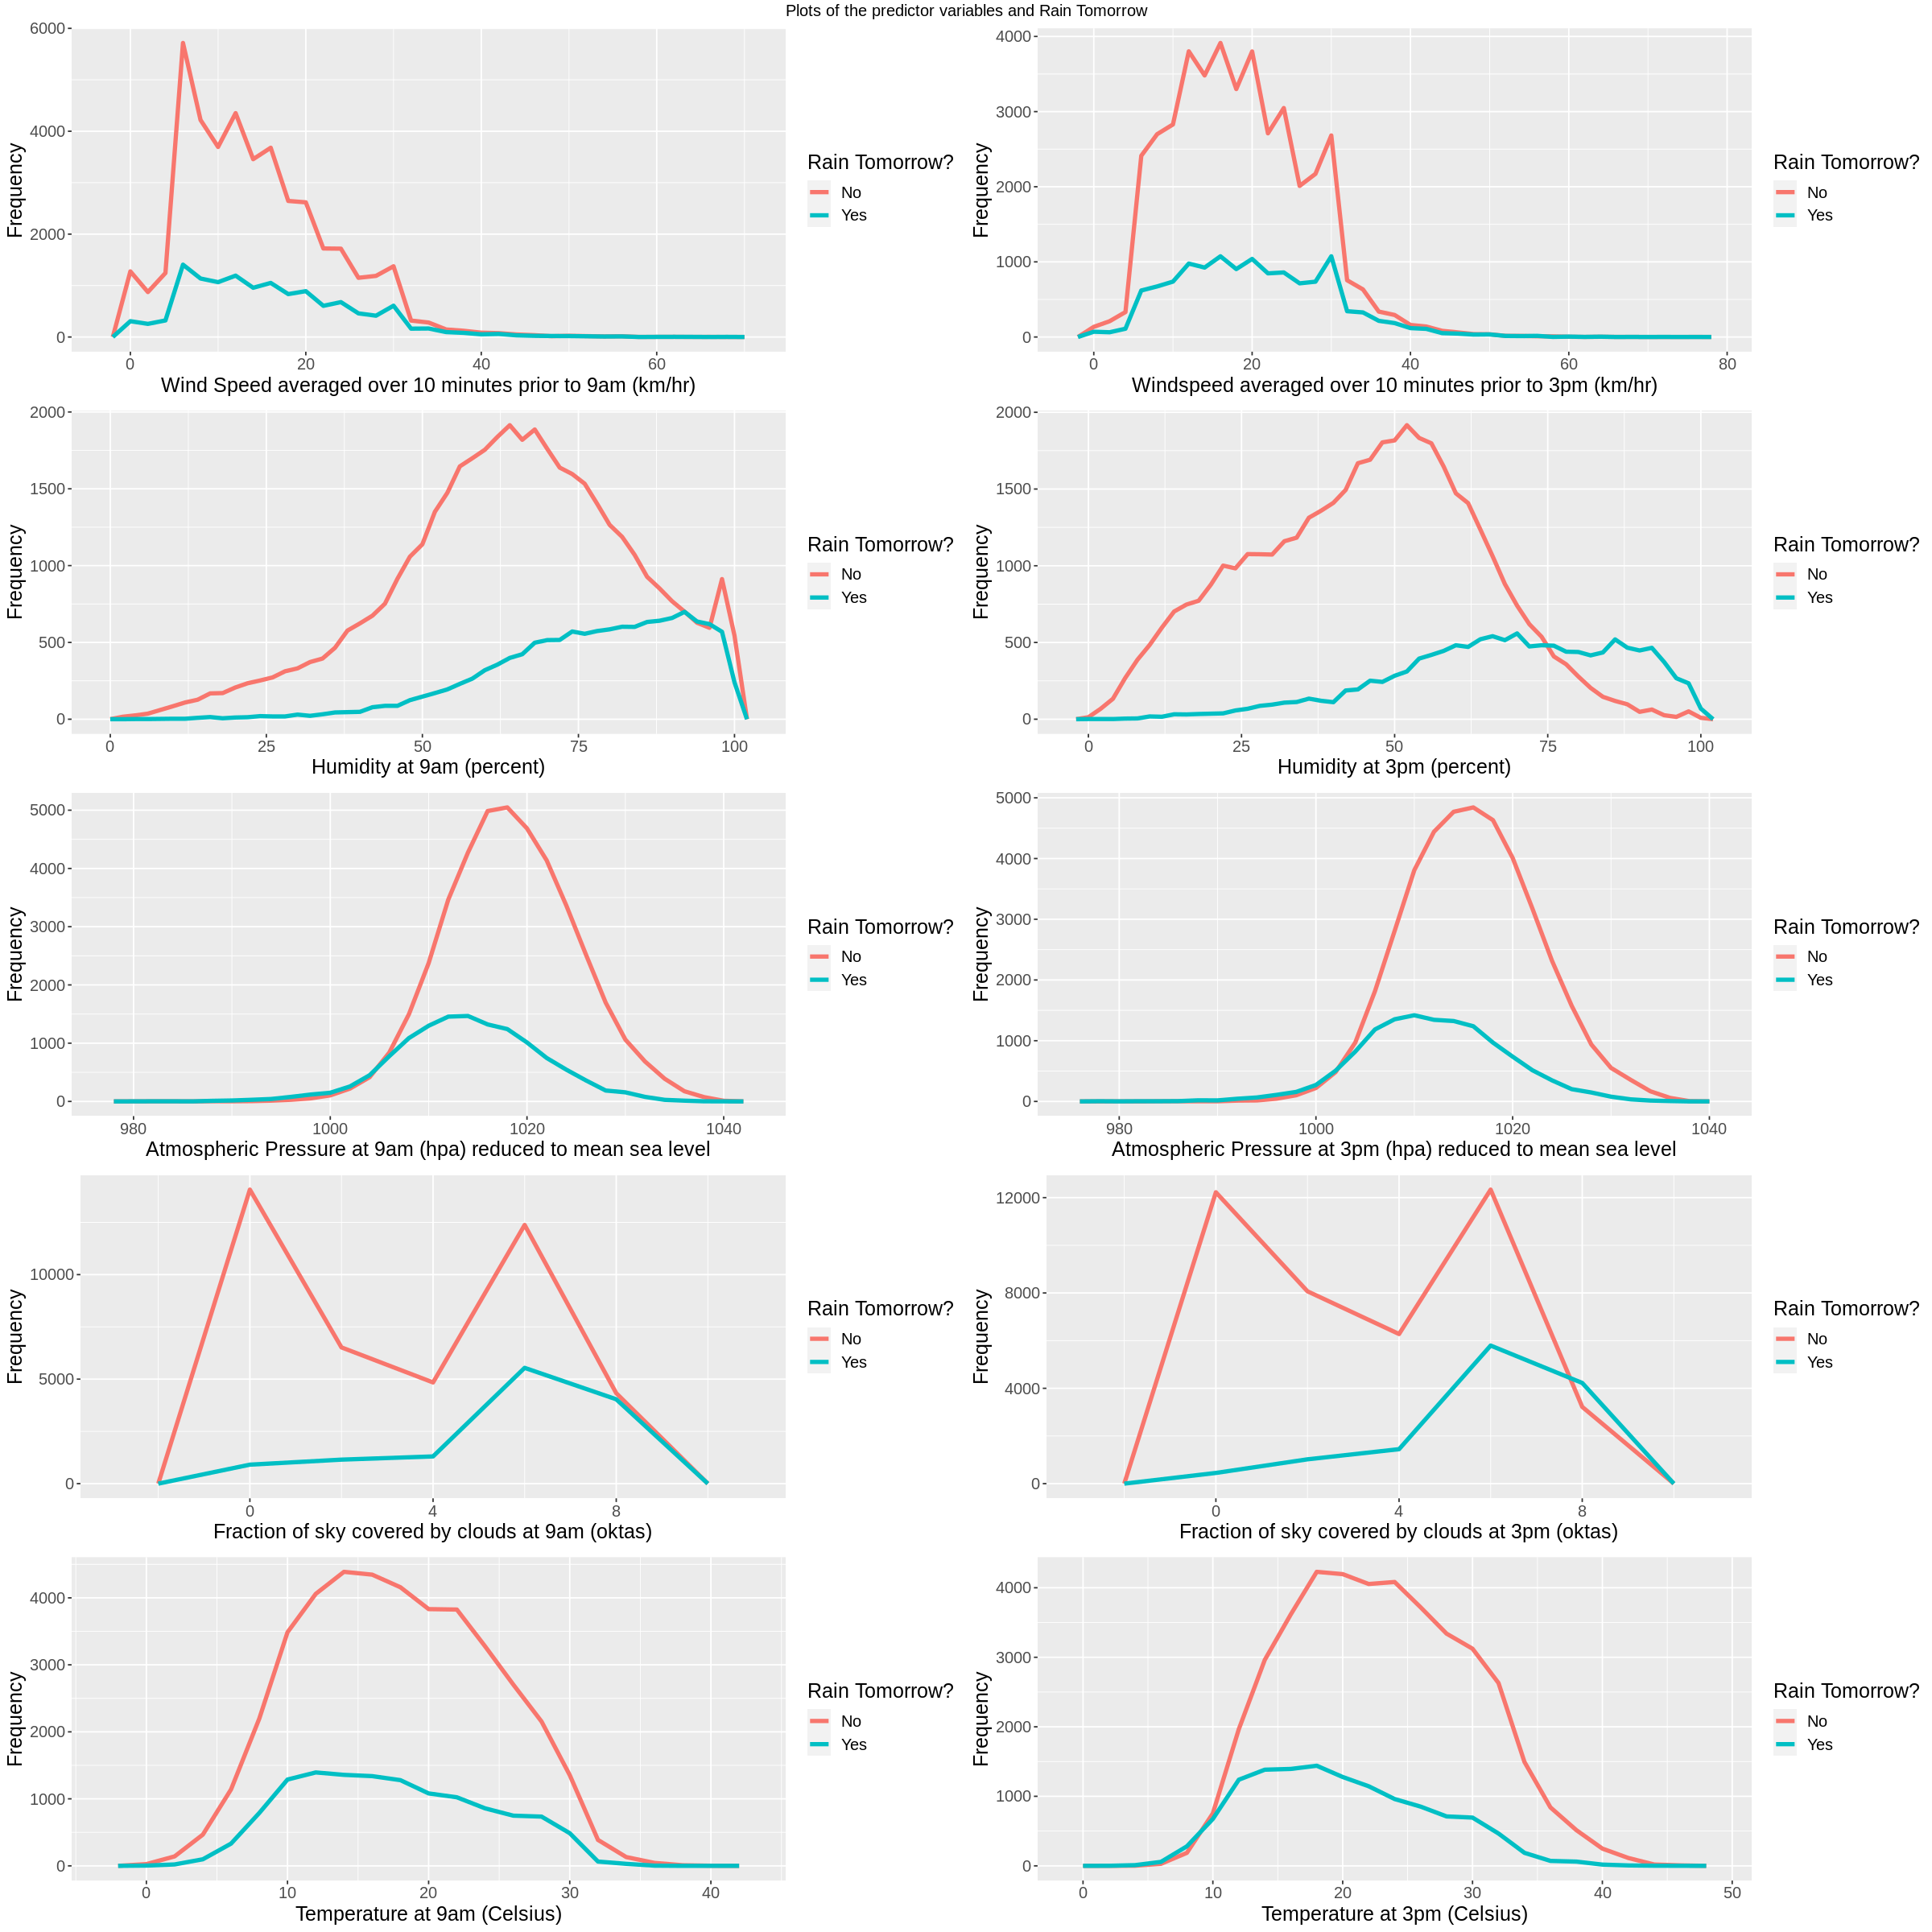

In [6]:
#set plot width and height (represents the size of entire plot grid)
options(repr.plot.height = 20, repr.plot.width = 20)

# Storing the names of each column to plot in a vector - to be provided as x in the aes of ggplot
loop.names = names(weather_train)[10:19]

# Storing the names of each x-labes in a vector - to be provided as x in the labs of ggplot
loop.lab = c("Wind Speed averaged over 10 minutes prior to 9am (km/hr)", "Windspeed averaged over 10 minutes prior to 3pm (km/hr)", 
               "Humidity at 9am (percent)", "Humidity at 3pm (percent)", 
               "Atmospheric Pressure at 9am (hpa) reduced to mean sea level", "Atmospheric Pressure at 3pm (hpa) reduced to mean sea level",
              "Fraction of sky covered by clouds at 9am (oktas)", "Fraction of sky covered by clouds at 3pm (oktas)",
              "Temperature at 9am (Celsius)", "Temperature at 3pm (Celsius)")


# initialize p (plot list) as an empty list with length 10
p <- vector('list', 10)

# Loops runs 10 times (once for each plot). Takes the nth item from loop.names and loop.title, prints a ggplot with each variable in the corresponding locations
for(i in 1:10) {
    
    #at each loop iteration, get the ith number in loop.names and loop.lab
    x_name <- unlist(weather_train[,nth(loop.names, i)])
    lab_name <- nth(loop.lab, i)
    
    # at each iteration, create a plot with x_name and lab_name. using aes_string to prevent lazy loding when p[[i]] is called later
    p[[i]] <- ggplot(weather_train, aes_string(x=x_name, colour = "RainTomorrow")) +
                            geom_freqpoly(binwidth=2, size = 1.5) +
                            theme(text = element_text(size = 15)) +
                            labs(color = "Rain Tomorrow?", 
                            x = lab_name, y = "Frequency")
    }


#arrange plots in a grid
grid.arrange(p[[1]], p[[2]], p[[3]], p[[4]], p[[5]], p[[6]], p[[7]], p[[8]], p[[9]], p[[10]], nrow=5, top = textGrob("Plots of the predictor variables and Rain Tomorrow"))


## Methods

We plan to build five separate KNN classifiers capturing 5 broad weather variables:
1. **Temperature** (`Temp9am` and `Temp3pm`)
2. **Humidity** (`Humidity9am` and `Humidity3pm`)
3. **Pressure** (`Pressure9am` and `Pressure3pm`)
4. **Windiness** (`WindSpeed9am`, `WindSpeed3pm`)
5. **Cloudiness** (`Cloud9am` and `Cloud3pm`)  

For each of these five broad variables, we will build and tune a classifier using 5-fold cross-validation. We will then evaluate which classifier (which variable) is the most predictive for `RainTomorrow`. Next, we will build a classifier using *all the numeric variables in the dataset* as predictors. This will let us compare the effectiveness of our chosen "heuristic" variable with the "best accuracy" we can achieve from our data. We may use KNN again, but if it becomes slow, we might use a more efficient algorithm. Finally, we will compare the accuracy of these classifiers to the "naive approach" of predicting "it will rain tomorrow if it rained today", and vice-versa, to see if our models actually contribute value.

**Possible visualizations include:**
- K versus accuracy plot
- Bar graph: accuracy of 7 classifiers
- Confusion matrix: best single classifier + complete classifier

## Expected outcomes and significance

We expect our best single variable classifier will be able to predict `RainTomorrow` accurately. The classifier incorporating all predictors will perform better, but not *much* better despite the additional computational expense. Both will perform better than the naive approach.

Finding variables highly associated with rain could be useful when we are unable to check the weather forecast on our phones. The most significant outcome will be predicting rain accurately despite using *significantly* less computing power and data than contemporary weather models.  

This would raise several questions for future exploration. If we were accurate despite limited computing power, are there more computationally efficient methods available to meteorologists if they *only* had to forecast rain? If rain can be predicted with just a few variables, how many of the sensors installed in weather stations are truly necessary %>% ? Finally, how effective would our approach be at regression?

### References

[1] https://www.nationalgeographic.com/environment/article/weather-forecasting  
[2] https://www.kaggle.com/jsphyg/weather-dataset-rattle-package?select=weatherAUS.csv